# Machine Learning with PyTorch

## Enhancing an Image Classifier 

* Starting with `torchvision.models`
* Retraining pretrained models
* Modifying Network Layers
* Understanding Effects of Network Structure

### Transfer learning

An important concept and tool to use once you have some basic idea of constructing neural networks is *transfer learning*.  Many of the things that a particular model learns can be applied to other problems that are somewhat similar in domain.  For example—perhaps the most used example of this—a great deal of image recognion amounts to be able to recognize object borders, general lighting conditions, overall shading region identification, and other overall image features.  Even if a model happens to be trained to recognize, e.g. houses versus kittens, much of the same pattern recognition would be helpful in distinguishing trucks from elephants.  Especially since training complex models can be extremely slow, and also simply because other people have done a great deal of work in finding good tagged image collections, it would be nice to re-use much of that work.

### Credit

As with several of the other lessons, I utilize and graciously thank other authors who have provided wondeful examples.  In this case, I found a blog post and code by Gilbert Adjei titled [Transfer Learning with PyTorch](https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72).  Looking through a fairly large number of similar writeups, I found his the most accessible and manageable of these.  I make some small modifications, but the credit for the code goes primarily to Adjei.

What Adjei looks at is using the pretrained `densenet121` model that is one of numerous image models included with PyTorch, and adapting it to identify images of cells that either are or are not parasitized by malaria.  A nice overview of densenet design is contained in the post [The Efficiency of Densenet](https://medium.com/@smallfishbigsea/densenet-2b0889854a92), by Hao Gao.  For this purpose, and of the image models in PyTorch would be similar to work with.  As an exercise, it would be good to try to apply the techniques in this lesson to other provided models, such as AlexNet, VGG, ResNet, SqueezeNet, Inception v3, GoogLeNet (most of those themselves come in a number of variations with differing layers, depths, and other design distinctions).

### Getting started

This lesson will take about 30-45 minutes to run, even with a fast GPU.  Probably many hours for CPU-only.  For those following along, it is a good idea to "Run All Cells" before we begin talking about the concepts.  

We need a fairly large dataset to run this model.  The collection of images contains about 28k of them, evenly divided between "Parasitized" and "Uninfected" classes.  The archive of all the images is a bit over 300 MiB.  I have hosted it on my personal website for convenience.  The underlying dataset comes from the US [National Institutes of Health](https://ceb.nlm.nih.gov/repositories/malaria-datasets/).  In some basic testing, my web host seems to be faster than any of the NIH website, the Kaggle site where it is mirrored, or the Google Drive location where Adjei uploaded it.

In [1]:
%%bash
cd data
wget -qc https://www.gnosis.cx/download/cell_images.zip
unzip -qu cell_images
tree cell_images/ | grep --context=2 '\(Parasitized\|Uninfected\)'

cell_images/
├── Parasitized
│   ├── C100P61ThinF_IMG_20150918_144104_cell_162.png
│   ├── C100P61ThinF_IMG_20150918_144104_cell_163.png
--
│   ├── C99P60ThinF_IMG_20150918_142334_cell_9.png
│   └── Thumbs.db
└── Uninfected
    ├── C100P61ThinF_IMG_20150918_144104_cell_128.png
    ├── C100P61ThinF_IMG_20150918_144104_cell_131.png


In this case, let us put all our imports together at the start, as we would in a standalone script.  In some notebooks I have interspersed the imports to emphasize what code they pertain to, but there are few enough here that the start is a better place.

In [2]:
%matplotlib inline
from glob import glob
from random import randrange
import os
from time import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

As usual, let us try to use CUDA GPU if possible.

In [3]:
# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    print("CUDA memory used:", torch.cuda.memory_allocated())
    device = torch.device('cuda') 

CUDA memory used: 0


#### A sample image

Selected more-or-less at random, we can look at one typical image from the dataset to get a sense of what a cell image looks like.  The dimensions of the images are not completely uniform, but they are all of similar size.

(115, 115, 3)

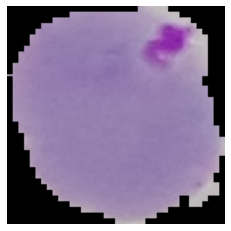

In [4]:
fname = 'img/cell-image.png'
image = Image.open(fname)
plt.imshow(image)
plt.axis('off')
    
np.array(image).shape

### Preparing images as inputs

As we usually do when working with image data, we wish to perform a pipeline of image transforms on our raw images to give them all the same tensor size that we wish to work with.  This may involve sizing, cropping, color adjustment, and other normalization of the images.

In the case of the training data, we add some additonal transforms to the pipeline.  In order to give the model a more robust set of training images, we randomly resize, flip, rotate, and add color jitter to the input images.  This should make the model capable of recognizing images that suffer from similar randomness in their original acquisition.

In [5]:
# Define your transforms for the training, validation, and testing sets
jitter_image = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                   transforms.RandomRotation(degrees=15),
                                   transforms.ColorJitter(),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.CenterCrop(size=224),  # Image net standards
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                   ])

In [6]:
clean_image = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], 
                                                       [0.229, 0.224, 0.225])])

### Loading the dataset

Our dataset is based around the directory structure of our samples. Each of the subdirectories, `Parasitized/` and `Uninfected/` in this case, correspond to one class in the target. We further split up the dataset into three sampler for training, validation, and testing.

In [7]:
# Load from subdirectories indicating classes
train_data = datasets.ImageFolder('data/cell_images/', transform=jitter_image)

# percentage of training set to use as validation & testing
valid_size, test_size = 0.2, 0.1

# Perform a train/test/validation split (sklearn train_test_split() might be more elegant)
ntrain = len(train_data)
indices = np.arange(ntrain)
np.random.shuffle(indices)

valid_split = int(valid_size * ntrain)
test_split = int((valid_size+test_size) * ntrain)

train_idx = indices[test_split:]
valid_idx = indices[:valid_split]
test_idx =  indices[valid_split:test_split]

# Samplers for training, validation, and testing batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Data loaders (combine dataset and sampler)
params = {'batch_size': 32, 'num_workers': os.cpu_count()}
train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, **params)
valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler, **params)
test_loader = torch.utils.data.DataLoader(train_data, sampler=test_sampler, **params)

print(f"Training: {len(train_idx):,}; Validation: {len(valid_idx):,}; Testing: {len(test_idx):,}")

Training: 19,291; Validation: 5,511; Testing: 2,756


### Load then enhance the pre-trained model

By freezing the parameters in the trained model, and only adding extra layers, what we accomplish is turning the entire previous model into basically just a utility for feature engineering.  Densenet121 is just a fancy way of generating some high level synthetic features that we would like to use in **our** model.

In [8]:
model = models.densenet121(pretrained=True)
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
for param in model.parameters():
    param.require_grad = False

# Define our own network, layers after the existing model, but basically just treating
# the pre-trained classifier as a feature engineering step
classifier = nn.Sequential(
                nn.Linear(1024, 460),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(460,2),
                nn.LogSoftmax(dim=1)
            )

model.classifier = classifier.to(device)
criterion = nn.NLLLoss()

# We want to only update the parameters of the classifier
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)

### Training the enhanced model

In the training loop below, we do something that is good general practice.  After each epoch, we see whether that epoch has the best loss (or meets some other metric we are aiming for) and snapshot it only if it represents an improvement.  When we load the model later, we will be working with the best epoch.  Of course, we could also later try further training the model with more epochs and/or new data.

In [10]:
epochs = 10
valid_loss_min = np.Inf    # Initial best loss as infinite
model_save_name = "Malaria.pt"
path = f"data/{model_save_name}"

for epoch in range(epochs):
    print("EPOCH", epoch)
    start = time()
    
    # Notify the model we are in training mode
    model.train()
    train_loss = 0.0
    valid_loss = 0.0
    print("Training: ", end='')
    for n, (inputs, labels) in enumerate(train_loader):
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if not n % 20:
            print('.', end='', flush=True)
    print(n, "loops")
           
    # Notify the model we are in eval mode (but also explicitly no_grad() for the work)
    model.eval()
    print("Validating: ", end='')
    with torch.no_grad():
        accuracy = 0
        for n, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            valid_loss += batch_loss.item()
            
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            if not n % 10:
                print('.', end='', flush=True)
        print(n, "loops")
                    
    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    valid_accuracy = accuracy/len(valid_loader) 
      
    # print training/validation statistics 
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss_min:.3f} ⟶ {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')

    # Only save the model if it is an improvement from best epoch
    if valid_loss <= valid_loss_min:
        print(f'Saving model...')
        torch.save(model.state_dict(), path)
        valid_loss_min = valid_loss
    else:
        print(f'Not saving because not best epoch')
       
    print(f"Time for epoch: {int(time() - start)} seconds\n")

EPOCH 0
Training: ...............................602 loops
Validating: ..................172 loops
Training Loss: 0.325
Validation loss: inf ⟶ 0.254
Validation Accuracy: 0.905
Saving model...
Time for epoch: 106 seconds

EPOCH 1
Training: ...............................602 loops
Validating: ..................172 loops
Training Loss: 0.279
Validation loss: 0.254 ⟶ 0.230
Validation Accuracy: 0.910
Saving model...
Time for epoch: 108 seconds

EPOCH 2
Training: ...............................602 loops
Validating: ..................172 loops
Training Loss: 0.273
Validation loss: 0.230 ⟶ 0.223
Validation Accuracy: 0.918
Saving model...
Time for epoch: 108 seconds

EPOCH 3
Training: ...............................602 loops
Validating: ..................172 loops
Training Loss: 0.271
Validation loss: 0.223 ⟶ 0.222
Validation Accuracy: 0.918
Saving model...
Time for epoch: 108 seconds

EPOCH 4
Training: ...............................602 loops
Validating: ..................172 loops
Training Lo

### Testing and visualizing results

Here we use the test set that was held entirely separate from the training.  The validation was performed with `torch.no_grad()` in effect, but conceivably that dataset could have some systematic bias that produced inaccurate feedback into the loss function.  By testing against an entirely independent dataset, we get a good sanity check about our accuracy.

In practice, if we do a reasonable train/test split on a reasonaly large dataset, there should be no important different between the validation and testing datasets, and we might often simply reuse the same dataset.

In [11]:
def test(model, criterion):
# monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: %2d%% (%2d/%2d)' % (
                100. * correct / total, correct, total))

test(model, criterion)

Test Loss: 0.196384
Test Accuracy: 92% (2541/2756)


#### Visualize a few categorized images

In [12]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = clean_image(image)[:3,:,:].unsqueeze(0)
    return image

def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted class
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

[4583] Diagnosed Parasitized (CORRECT)


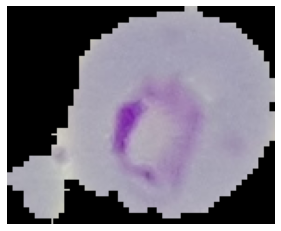

[1443] Diagnosed Parasitized (CORRECT)


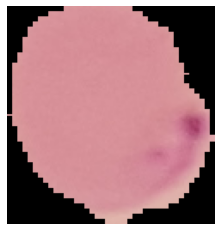

[10629] Diagnosed Uninfected (CORRECT)


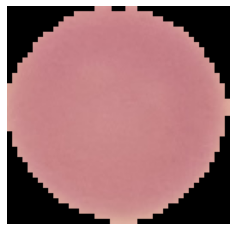

[2065] Diagnosed Parasitized (MISTAKE)


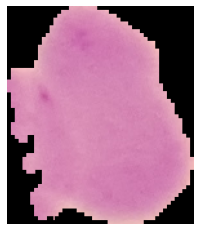

In [13]:
class_names=['Parasitized','Uninfected']
inf = np.array(glob("data/cell_images/Parasitized/*"))
uninf = np.array(glob("data/cell_images/Uninfected/*"))

for _ in range(2):
    i = randrange(len(inf))
    fname = inf[i]
    img = Image.open(fname)
    if predict_malaria(model, class_names, fname) == 'Parasitized':
        print(f'[{i}] Diagnosed Parasitized (CORRECT)')
    else:
        print(f'[{i}] Diagnosed Uninfected (MISTAKE)')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
for _ in range(2):
    i = randrange(len(uninf))
    fname = uninf[i]
    img = Image.open(fname)
    if predict_malaria(model, class_names, fname) == 'Uninfected':
        print(f'[{i}] Diagnosed Uninfected (CORRECT)')
    else:
        print(f'[{i}] Diagnosed Parasitized (MISTAKE)')       
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Next Lesson

We have looked at quite a few capabilities in PyTorch and associated tools.  The next step is to go out and use these lovely tools in your own projects.  I'd love to hear back on what you find and see what you create.  Contact me via the repository for this training material (file issues, email me, propose PRs, whatever).

Thanks. David Mertz.